In [2]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from typing import Any, Callable, List, Optional, Type, Union

from torch import Tensor
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)



1.12.1+cu113 0.13.1+cu113


In [3]:
dataset = datasets.CIFAR100("~/.torch", download=True)
transform_operation = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
])

def reverse_transform(image):
    """ reverse the normalized image back to JPG format """
    output = image.detach().cpu().numpy().transpose(1, 2, 0)*255
    output[output > 255] = 255
    output[output < 0] = 0
    output = output.astype(np.uint8)
    return output

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"


loss = torch.nn.CrossEntropyLoss()

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.torch/cifar-100-python.tar.gz to /root/.torch


In [4]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out
    
lenet = LeNet().to(device)
    
lenet.apply(weights_init)


LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
    (6): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=100, bias=True)
  )
)

## Honest participants
This is the image used by the honest trainer, where only the gradients will be shared to other trainers (under the name original_derivatives)

In [9]:
example_index = 25
ground_truth_data = transform_operation(dataset[example_index][0]).to(device).unsqueeze(0)
ground_truth_label = torch.Tensor([dataset[example_index][1]]).to(device).long()
ground_truth_label = torch.nn.functional.one_hot(ground_truth_label, num_classes=100)

model_prediction = lenet(ground_truth_data)

predicted_loss = loss(model_prediction, ground_truth_label.float())

derivatives = torch.autograd.grad(predicted_loss, lenet.parameters())


original_derivatives = [layer_derivative.detach().clone() for layer_derivative in derivatives]

Plot the ground truth image

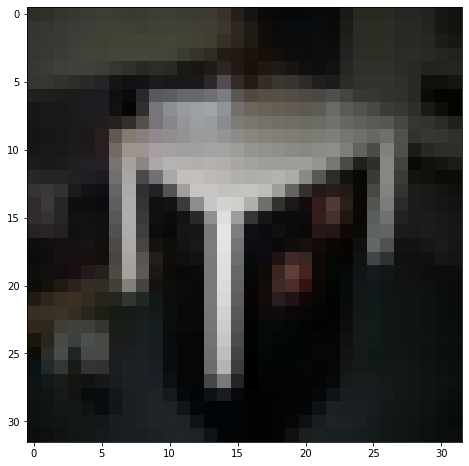

In [10]:
ground_truth_jpg = reverse_transform(ground_truth_data[0])
plt.figure(figsize=(8, 8))
plt.imshow(ground_truth_jpg)

## Generate dummy data and dummy label
Here, we will generate an image using random pixel and random label

Dummy label is 62.


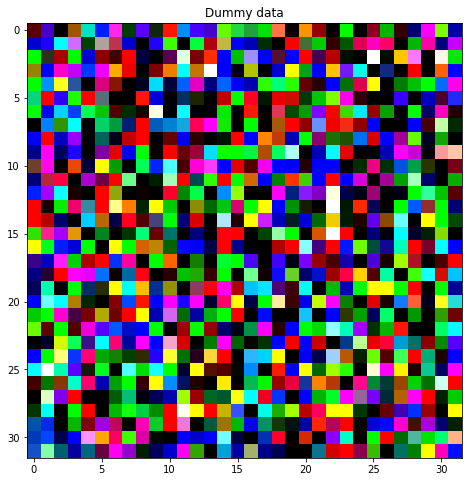

In [12]:
dummy_data = torch.randn(ground_truth_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(ground_truth_label.size()).to(device).requires_grad_(True)

dummy_data_jpg = reverse_transform(dummy_data[0])
plt.figure(figsize=(8, 8))
plt.imshow(dummy_data_jpg)
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [13]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = lenet(dummy_data) 
        dummy_onehot_label = torch.nn.functional.softmax(dummy_label, dim=-1)
        dummy_loss = loss(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, lenet.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_derivatives): 
            grad_diff += ((gx - gy)**2).sum()
            grad_count += gx.nelement()
        #grad_diff = grad_diff / grad_count
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 1 == 0: 
        current_loss = closure()
        print(iters, datetime.now().isoformat(), "%.6f" % current_loss.item())
    history.append(reverse_transform(dummy_data[0]))

0 2022-08-30T06:15:05.792684 52.523125
1 2022-08-30T06:15:05.968685 27.553679
2 2022-08-30T06:15:06.189194 17.067045
3 2022-08-30T06:15:06.457032 12.017253
4 2022-08-30T06:15:06.765513 9.358714
5 2022-08-30T06:15:07.115138 7.482831
6 2022-08-30T06:15:07.458911 6.075782
7 2022-08-30T06:15:07.790824 5.026010
8 2022-08-30T06:15:08.112897 4.167642
9 2022-08-30T06:15:08.438053 3.443437
10 2022-08-30T06:15:08.746927 2.911340
11 2022-08-30T06:15:09.079599 2.491514
12 2022-08-30T06:15:09.405445 2.191596
13 2022-08-30T06:15:09.715614 1.828045
14 2022-08-30T06:15:10.033509 1.514665
15 2022-08-30T06:15:10.350130 1.315787
16 2022-08-30T06:15:10.670994 1.163870
17 2022-08-30T06:15:10.982698 1.041767
18 2022-08-30T06:15:11.308062 0.930585
19 2022-08-30T06:15:11.629364 0.840079
20 2022-08-30T06:15:11.956224 0.769033
21 2022-08-30T06:15:12.283311 0.706121
22 2022-08-30T06:15:12.607027 0.657007
23 2022-08-30T06:15:12.921585 0.611706
24 2022-08-30T06:15:13.293439 0.565788
25 2022-08-30T06:15:13.728227 0

# Plot the evolution of the image

Dummy label is 84.


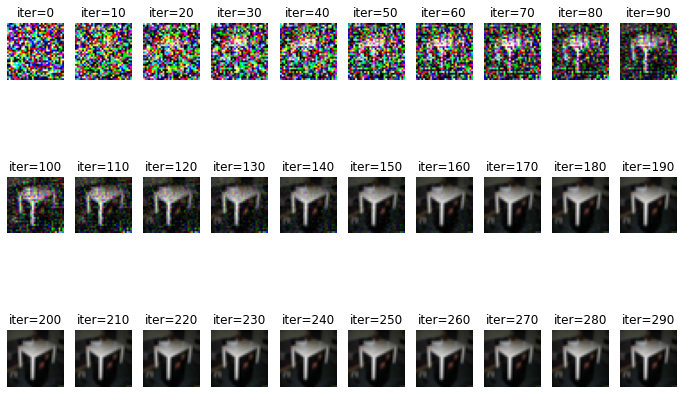

In [14]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i*10])
  plt.title("iter=%d" % (i*10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

# Plot the final output

Text(0.5, 1.0, 'Dummy data')

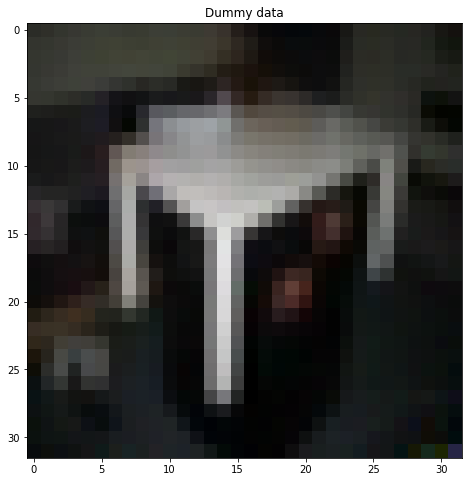

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(history[-1])
plt.title("Dummy data")

# Plot MSE vs steps

Text(0.5, 1.0, 'MSE vs step of Lenet')

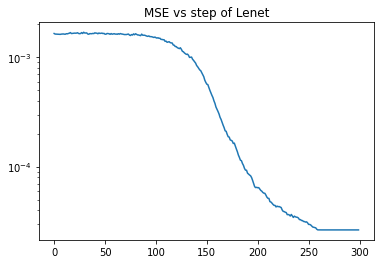

In [16]:
mse_array = [
    np.mean((ground_truth_jpg - history[i])**2)/255**2  for i in range(len(history))
]

plt.semilogy(np.arange(len(history)), mse_array)
plt.title("MSE vs step of Lenet")

In [18]:
print(mse_array)

[0.0016530951637190824, 0.0016338567698321157, 0.001632344931436627, 0.0016292361511598104, 0.0016307379773804948, 0.0016248558246828144, 0.0016233189558503142, 0.0016312636165577343, 0.0016341220924644367, 0.0016376413719082403, 0.0016304376121363579, 0.001628234933679354, 0.0016458563613353837, 0.0016414610165961811, 0.001653891131616045, 0.0016650947552223504, 0.0016843832099833398, 0.001651413118351916, 0.0016561138344226578, 0.0016580111415481226, 0.0016661660579264386, 0.0016639433551198259, 0.0016665164840445983, 0.0016797425669614252, 0.00165383606465462, 0.001646982731000897, 0.0016526946767269, 0.0016848337578495452, 0.0016535557237600924, 0.001697363994617455, 0.0016708517557349738, 0.0016700407695758041, 0.0016744561386646162, 0.0016362997404844291, 0.001627078527489427, 0.0016488950563885686, 0.001645626081314879, 0.0016452606369345125, 0.0016559586457131873, 0.0016501065295399205, 0.0016766738353838266, 0.0016654351691657056, 0.0016647092864923749, 0.001643848920287069, 0